In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from scipy.stats import levy_stable

# Langevin Monte Carlo

New samples are proposed by simulating the Langevin Stochastic Differential Equation (SDE) which is given by

$$dX_t = -\nabla U(X_t)dt + \sqrt{2}dB_t$$

where $U$ is the potential function and $B_t$ is the standard Brownian motion.

### Example
Let $U(\mathbf{z}) = \frac{1}{2}\left(\frac{\|\mathbf{z}\|-2}{0.4}\right)^2 - \log\left(e^{-0.5\left[\frac{\mathbf{z}_1 - 2}{0.6}\right]} + e^{-0.5\left[\frac{\mathbf{z}_1 + 2}{0.6}\right]}\right)$, and $p(\mathbf{z}) \propto e^{-U(\mathbf{z})}$ be the distribution we want to sample from.

Let's visualize the (unnormalized) density.

In [70]:
def npdensity1(z):
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

def npdensity2(z):
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return np.exp(-u)

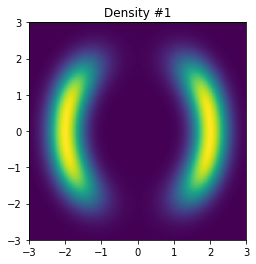

In [71]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity1(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Density #1')
plt.show()

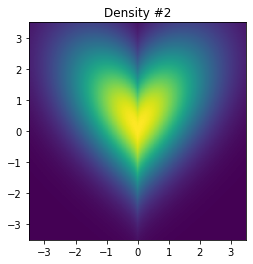

In [72]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity2(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Density #2')
plt.show()

## Unadjusted Langevin Algorithm (ULA)

The Langevin SDE can be simulated using the Euler-Maruyama scheme as follows

$$X_{k+1} = X_{k} - \gamma_{k+1}\nabla U(X_k) + \sqrt{2\gamma_{k+1}}Z_{k+1}$$

where $\gamma_{k+1}$ is the step size and $Z_{k+1}$ is a sample from $\mathcal{N}(0, I)$ respectively at the $k+1$-th time-step.

In practice, there are various tricks to set $\gamma_{k+1}$ and $X_0$, the initial seed. However, in the following examples, I've used a constant step-size and have sampled $X_0$ from $\mathcal{N}(0, I)$.

The above simulation of Langevin dynamics can be used to draw samples from densities of the form $p(x) = \frac{e^{-U(x)}}{Z}$ where Z may or may not be known. It is assumed that the gradient of $U$ is $L$-Lipschtiz.

In [73]:
def potential1(z):
    z = z.view(-1, 2).double()
    z1, z2 = z[:, 0], z[:, 1]
    norm = torch.norm(z, p=2, dim=1)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return u

def potential2(z):
    z = z.view(-1, 2).double()
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return u

def npdensity1(z):

    return torch.exp(-potential1(z))

def npdensity2(z):

    return torch.exp(-potential2(z))

fractional differentiation : $
\mathcal{D}^{\gamma} f(x) \triangleq \mathcal{F}^{-1}\left\{\mid \omega |^{\gamma} \hat{f}(\omega)\right\}
$

In [74]:

def fractional_diff(func, gamma, Z):

    result = func(Z).detach().numpy()
    norm = torch.norm(Z).detach().numpy()

    res = np.fft.irfft2(norm ** gamma * np.fft.rfft2(result), s=Z.shape)
    return torch.from_numpy(res).double()

$
f_{\pi}(x) \triangleq-\phi(x) \partial_{x} U(x)
$

In [75]:
def f_pi(Z, potential, density):
    Z.requires_grad_()
    U = potential(Z)
    grad = torch.autograd.grad(U, Z)[0]
    return - density(Z) * grad

In [94]:
def unadjusted_langevin_algorithm(potential, density, alpha=2, n_samples=50000, step=0.1):
    burn_in = 10000
    Z0 = torch.randn(1, 2).double()

    Zi = Z0
    samples = []
    random_vars = levy_stable.rvs(alpha, beta=0, size=2 * (n_samples + burn_in))
    random_vars = torch.from_numpy(random_vars.reshape((random_vars.shape[0] // 2, 2)))


    for i in tqdm(range(n_samples + burn_in)):
        f_pi_ = lambda Z: f_pi(Z, potential, density)
        diff_f = fractional_diff(f_pi_, alpha-2, Zi)
        b = diff_f / (density(Zi) + 1e-10)

        Zi = Zi.detach() + step * b + step ** (1/alpha) * random_vars[i]
        samples.append(Zi.detach().numpy())


    return np.concatenate(samples, 0)[burn_in:]

Run the ULA and render the empirical density.

In [108]:

samples1 = unadjusted_langevin_algorithm(potential1, npdensity1, alpha=1.8, step=0.03)
samples2 = unadjusted_langevin_algorithm(potential2, npdensity2, alpha=1.8, step=0.03)

/var/folders/57/s8ftltw13n1dfhbmr5fqsggw0000gn/T/ipykernel_10152/1494258089.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_samples + burn_in)):


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

In [112]:
indices = ~np.logical_or(np.isnan(samples1)[:, 0], np.isnan(samples1)[:, 1])
samples1 = samples1[indices]

indices = ~np.logical_or(np.isnan(samples2)[:, 0], np.isnan(samples2)[:, 1])
samples2 = samples2[indices]



In [113]:
samples1.shape, samples2.shape

((0, 2), (50000, 2))

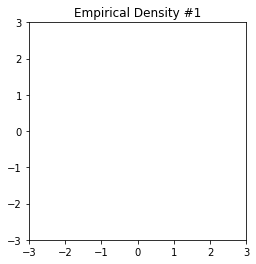

In [114]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()

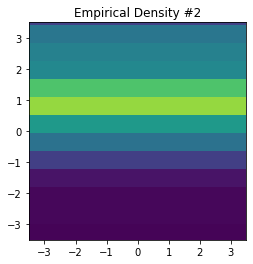

In [124]:
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

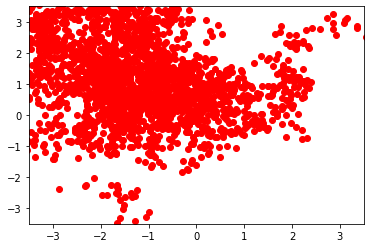

In [119]:
plt.plot(samples2[:,0], samples2[:,1], 'ro')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.show()

array([[   13.26555179,    24.67794081],
       [   13.24600736,    24.66171929],
       [   13.65760229,    24.44971351],
       ...,
       [-3899.56916685,   -15.33601241],
       [-3900.10075912,   -15.45232818],
       [-3900.1754063 ,   -15.36147325]])